In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [6]:
# package from the pytorch side
import copy
import csv
import sys
import torch
from pytorch_utils import *

In [7]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import networkx as nx
import metis
import sklearn
import time
# import models
import numpy as np
import partition_utils
import tensorflow as tf
import utils

In [8]:
# tf.compat.v1.logging.ERROR
# verbose information: tf.logging.INFO  

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # Sets the threshold for what messages will be logged.
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Num GPUs Available:  0
Num CPUs Available:  1


### GCN model used

In [9]:
import inits
import tensorflow as tf
import metrics

def sparse_dropout(x, keep_prob, noise_shape):
    """Dropout for sparse tensors."""
    random_tensor = keep_prob
    random_tensor += tf.compat.v1.random_uniform(noise_shape)
    dropout_mask = tf.compat.v1.cast(tf.compat.v1.floor(random_tensor), dtype=tf.compat.v1.bool)
    pre_out = tf.compat.v1.sparse_retain(x, dropout_mask)
    return pre_out * (1. / keep_prob)


def dot(x, y, sparse=False):
    """Wrapper for tf.compat.v1.matmul (sparse vs dense)."""
    if sparse:
        res = tf.compat.v1.sparse_tensor_dense_matmul(x, y)
    else:
        res = tf.compat.v1.matmul(x, y)
    return res


def layernorm(x, offset, scale):
    mean, variance = tf.compat.v1.nn.moments(x, axes=[1], keep_dims=True)
    return tf.compat.v1.nn.batch_normalization(x, mean, variance, offset, scale, 1e-9)


class Layer(object):
    """Base layer class.

    Defines basic API for all layer objects.
    Implementation inspired by keras (http://keras.io).

    # Properties
        name: String, defines the variable scope of the layer.
        logging: Boolean, switches Tensorflow histogram logging on/off

    # Methods
        _call(inputs): Defines computation graph of layer
            (i.e. takes input, returns output)
        __call__(inputs): Wrapper for _call()
        _log_vars(): Log all variables
    """

    def __init__(self, name = None, logging = False):
        
        if not name:
            layer = self.__class__.__name__.lower()
            name = layer + '_' 

        self.name = name
        
        self.vars = {}
        self.logging = logging
        
        self.sparse_inputs = False

    def _call(self, inputs):
        return inputs


    def __call__(self, inputs):
        with tf.compat.v1.name_scope(self.name):
            if self.logging and not self.sparse_inputs:
                tf.compat.v1.summary.histogram(self.name + '/inputs', inputs)

        outputs = self._call(inputs)

        if self.logging:
            tf.compat.v1.summary.histogram(self.name + '/outputs', outputs)
        return outputs

    def _log_vars(self):
        for var in self.vars:
            tf.compat.v1.summary.histogram(self.name + '/vars/' + var, self.vars[var])

            
class GraphConvolution(Layer):
    """Graph convolution layer."""

    def __init__(self, input_dim, output_dim, placeholders,
               dropout=0., sparse_inputs=False, act=tf.nn.relu, bias=False, featureless=False, norm=False, precalc=False,
               name = None, logging = False):
        super(GraphConvolution, self).__init__(name = name, logging = logging)
#         print('During the constructor of GCN layer, input dim: {} ; output dim: {}'.format(input_dim, output_dim))

        if dropout:
            self.dropout = placeholders['dropout']
        else:
            self.dropout = 0.

        self.act = act
        self.support = placeholders['support']

        self.sparse_inputs = sparse_inputs
        self.featureless = featureless
        self.bias = bias
        self.norm = norm
        self.precalc = precalc

        # helper variable for sparse dropout
        # self.num_features_nonzero = placeholders['num_features_nonzero']

        with tf.variable_scope(self.name + '_vars'):
            self.vars['weights'] = inits.glorot([input_dim, output_dim], name='weights')
            if self.bias:
                self.vars['bias'] = inits.zeros([output_dim], name='bias')

            if self.norm:
                self.vars['offset'] = inits.zeros([1, output_dim], name='offset')
                self.vars['scale'] = inits.ones([1, output_dim], name='scale')

        if self.logging:
            self._log_vars()
    

    def _call(self, inputs):
        x = inputs

        # convolve
        if self.precalc:
            support = x
        else:
            support = dot(self.support, x, sparse=True)
            support = tf.concat((support, x), axis=1)

        # dropout
        support = tf.nn.dropout(support, rate = self.dropout)

#         tf.Print(support, [support], "During the call of GCN layer, final input to be multiplied with weights: ")

#         print('\n inside the call of convolutiongraph layer: ')
#         print('support vecotr dimension is : {} ;'.format(support.shape), 'weight matrix dimension is : {} ;'.format(self.vars['weights'].shape))

        output = dot(support, self.vars['weights'], sparse=self.sparse_inputs)

        # bias
        if self.bias:
            output += self.vars['bias']

        with tf.variable_scope(self.name + '_vars'):
            if self.norm:
                output = layernorm(output, self.vars['offset'], self.vars['scale'])

        return self.act(output)


### Construct GCN layer nets

In [10]:
"""Collections of different Models."""


class Model(object):
    """Model class to be inherited."""

    def __init__(self, weight_decay = 0, num_layers = 2, name = None, logging = False, multilabel = False, norm = False, precalc = False):
        self.weight_decay = weight_decay
        
        self.num_layers = num_layers
        if not name:
            name = self.__class__.__name__.lower()
        self.name = name

        self.logging = logging
        self.multilabel = multilabel
        self.norm = norm
        self.precalc = precalc

        self.vars = {}
        self.placeholders = {}

        self.layers = []
        self.activations = []

        self.inputs = None
        self.outputs = None

        self.loss = 0
        self.accuracy = 0
        self.pred = 0
        self.optimizer = None
        self.opt_op = None

    def _build(self):
        raise NotImplementedError

    def build(self):
        """Wrapper for _build()."""
        with tf.variable_scope(self.name):
            self._build()

        # Build sequential layer model
        self.activations.append(self.inputs)
        
        # debug to output the embedding:
#         self.hidden1 = layer(self.activations[-1])
        
        for layer in self.layers:
            hidden = layer(self.activations[-1])
        
            if isinstance(hidden, tuple):
                tf.logging.info('{} shape = {}'.format(layer.name, hidden[0].get_shape()))
            else:
                tf.logging.info('{} shape = {}'.format(layer.name, hidden.get_shape()))

            self.activations.append(hidden)
            
        self.outputs = self.activations[-1]

        # Store model variables for easy access
        variables = tf.get_collection( tf.GraphKeys.GLOBAL_VARIABLES, scope=self.name)
        # GLOBAL_VARIABLES: the default collection of Variable objects, shared across distributed environment (model variables are subset of these).
        self.vars = variables
        for k in self.vars:
            tf.logging.info((k.name, k.get_shape()))

        # Build metrics
        self._loss()
        self._accuracy()
        self._predict()

        self.opt_op = self.optimizer.minimize(self.loss)

    def _loss(self):
        """Construct the loss function."""
        # Weight decay loss
        if self.weight_decay > 0.0:
            for var in self.layers[0].vars.values():
                self.loss += self.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
        if self.multilabel:
            self.loss += metrics.masked_sigmoid_cross_entropy(self.outputs, self.placeholders['labels'], self.placeholders['labels_mask'])
        else:
            self.loss += metrics.masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'], self.placeholders['labels_mask'])

    def _accuracy(self):
        if self.multilabel:
            # use the outputs directly, without any softmax or sigmoid
            self.accuracy = metrics.masked_accuracy_multilabel(self.outputs, self.placeholders['labels'], self.placeholders['labels_mask'])
        else:
            self.accuracy = metrics.masked_accuracy(self.outputs, self.placeholders['labels'], self.placeholders['labels_mask'])

    def _predict(self):
        # this prediction to generate the possibility distribution is not used
        if self.multilabel:
            self.pred = tf.nn.sigmoid(self.outputs)
        else:
            self.pred = tf.nn.softmax(self.outputs)

    def save(self, sess=None):
        if not sess:
            raise AttributeError('TensorFlow session not provided.')
        saver = tf.train.Saver(self.vars)
        save_path = saver.save(sess, './tmp/%s.ckpt' % self.name)
        tf.logging.info('Model saved in file:', save_path)

    def load(self, sess=None):
        if not sess:
            raise AttributeError('TensorFlow session not provided.')
        saver = tf.train.Saver(self.vars)
        save_path = './tmp/%s.ckpt' % self.name
        saver.restore(sess, save_path)
        tf.logging.info('Model restored from file:', save_path)


class GCN(Model):
    """Implementation of GCN model."""

    def __init__(self, placeholders, input_dim, output_dim, hidden_neuron_num, learning_rate = 0.01, 
                 num_layers = 3, name = None, logging = False, multilabel = False, norm = False, precalc = False):
        
        self.learning_rate = learning_rate
        self.hidden1 = hidden_neuron_num
        
        super(GCN, self).__init__(weight_decay = 0, num_layers = num_layers, name = name, logging = logging, \
                                  multilabel = multilabel, norm = norm, precalc = precalc)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
#         self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.output_dim = output_dim
    
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate)

        self.build()

    def _build(self):
        self.layers.append(
            GraphConvolution(
                input_dim = self.input_dim if self.precalc else self.input_dim * 2,
                output_dim = self.hidden1,
                placeholders = self.placeholders,
                act=tf.nn.relu,
                dropout = True,
                sparse_inputs = False,
                logging = self.logging,
                norm = self.norm,
                precalc = self.precalc))
        
        for _ in range(self.num_layers - 2):
            self.layers.append(
              GraphConvolution(
                  input_dim = self.hidden1 * 2,
                  output_dim = self.hidden1,
                  placeholders = self.placeholders,
                  act=tf.nn.relu,
                  dropout = True,
                  sparse_inputs = False,
                  logging = self.logging,
                  norm = self.norm,
                  precalc = False))
            
        self.layers.append(
            GraphConvolution(
                input_dim = self.hidden1 * 2,
                output_dim = self.output_dim,
                placeholders = self.placeholders,
                act = lambda x: x,    # for the last layer, no relu
                dropout = True,
                logging = self.logging,
                norm = False,
                precalc = False))


### Utility func

In [11]:
from torch_scatter import scatter_add
from torch_geometric.utils import add_remaining_self_loops

def get_edge_weight(edge_index, num_nodes, edge_weight = None, improved = False, dtype=None, store_path='./tmp/'):
    """
        edge_index(ndarray): undirected edge index (two-directions both included)
        num_nodes(int):  number of nodes inside the graph
        edge_weight(ndarray): if any weights already assigned, otherwise will be generated 
        improved(boolean):   may assign 2 to the self loop weight if true
        store_path(string): the path of the folder to contain all the clustering information files
    """
    # calculate the global graph properties, global edge weights
    if edge_weight is None:
        edge_weight = torch.ones((edge_index.size(1), ), dtype=dtype, device=edge_index.device)

    fill_value = 1 if not improved else 2
    # there are num_nodes self-loop edges added after the edge_index
    edge_index, edge_weight = add_remaining_self_loops(edge_index, edge_weight, fill_value, num_nodes)

    row, col = edge_index   
    # row includes the starting points of the edges  (first row of edge_index)
    # col includes the ending points of the edges   (second row of edge_index)

    deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)
    # row records the source nodes, which is the index we are trying to add
    # deg will record the out-degree of each node of x_i in all edges (x_i, x_j) including self_loops

    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    # normalize the edge weight
    normalized_edge_weight = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

    # transfer from tensor to the numpy to construct the dict for the edge_weights
    edge_index = edge_index.t().numpy()
    normalized_edge_weight = normalized_edge_weight.numpy()

    num_edge = edge_index.shape[0]

    output = ([edge_index[i][0], edge_index[i][1], normalized_edge_weight[i]] for i in range(num_edge))

    # output the edge weights as the csv file
    input_edge_weight_txt_file = store_path + 'input_edge_weight_list.csv'
    os.makedirs(os.path.dirname(input_edge_weight_txt_file), exist_ok=True)
    with open(input_edge_weight_txt_file, 'w', newline='\n') as fp:
        wr = csv.writer(fp, delimiter = ' ')
        for line in output:
            wr.writerow(line)
    return input_edge_weight_txt_file

### Clustering the data

In [12]:
import metis
import random
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from itertools import chain
import scipy.sparse as sp

def construct_adj(edges, nodes_count):
    # Compressed Sparse Row matrix
    # csr_matrix((data, ij), [shape=(M, N)])
    # where data and ij satisfy the relationship a[ij[0, k], ij[1, k]] = data[k]
    adj = sp.csr_matrix( ( np.ones((edges.shape[0]), dtype=np.float32), (edges[:, 0], edges[:, 1]) ), shape=(nodes_count, nodes_count) )
    adj += adj.transpose()   # double the weight of each edge if it is two direction
    return adj

class ClusteringMachine(object):
    """
    Clustering the graph, feature set and label. Performed on the CPU side
    """
    def __init__(self, edge_index, features, label, tmp_folder = './tmp/', info_folder = './info/'):
        """
        :param edge_index: COO format of the edge indices.
        :param features: Feature matrix (ndarray).
        :param label: label vector (ndarray).
        :tmp_folder(string): the path of the folder to contain all the clustering information files
        """
        self.features = features
        self.label = label
        self._set_sizes()
        self.edge_index = edge_index
        # store the information folder for memory tracing
        self.tmp_folder = tmp_folder
        self.info_folder = info_folder
        
        # first, use the get edge weights func to construct the two-sided self-loop added graph
        edge_weight_file = self.tmp_folder + 'input_edge_weight_list.csv'
        self.graph = nx.read_weighted_edgelist(edge_weight_file, create_using = nx.Graph, nodetype = int)
        
#         # second construct teh graph directly from the edge_list, here we are lacking the self-loop age
#         tmp = edge_index.t().numpy().tolist()
#         self.graph = nx.from_edgelist(tmp)
        
    def _set_sizes(self):
        """
        Setting the feature and class count.
        """
        self.node_count = self.features.shape[0]
        self.feature_count = self.features.shape[1]    # features all always in the columns
        self.label_count = len(np.unique(self.label.numpy()) )
    
    # 2) first assign train, test, validation nodes, split edges; this is based on the assumption that the clustering is no longer that important
    def split_whole_nodes_edges_then_cluster(self, validation_ratio, test_ratio, normalize = False, precalc = True):
        """
            Only split nodes
            First create train-test splits, then split train and validation into different batch seeds
            Input:  
                1) ratio of test, validation
                2) partition number of train nodes, test nodes, validation nodes
            Output:
                1) sg_validation_nodes_global, sg_train_nodes_global, sg_test_nodes_global
        """
        relative_validation_ratio = (validation_ratio) / (1 - test_ratio)
        
        # first divide the nodes for the whole graph, result will always be a list of lists 
        model_nodes_global, self.test_nodes_global = train_test_split(list(self.graph.nodes()), test_size = test_ratio)
        self.train_nodes_global, self.valid_nodes_global = train_test_split(model_nodes_global, test_size = relative_validation_ratio)
        
        edges = np.array(self.graph.edges(), dtype=np.int32)
        self.feats = np.array(self.features.numpy(), dtype=np.float32)
        
        
#         # normalize all the features
#         if normalize:
#             scaler = sklearn.preprocessing.StandardScaler()
#             scaler.fit(feats)
#             feats = scaler.transform(feats)
        
        classes = np.array(self.label.numpy(), dtype=np.int32)

        # construct the 1-hot labels:
        self.labels = np.zeros((self.node_count, self.label_count), dtype=np.float32)
        for i, label in enumerate(classes):
            self.labels[i, label] = 1
            
        self.full_adj = construct_adj(edges, self.node_count)
    
    def train_batch_generation(self, train_batch_num = 2, diag_lambda = -1, precalc = True, mini_cluster_num = 1):
        # all the properties needed for the training
        train_subgraph = self.graph.subgraph(self.train_nodes_global)
        train_edges = np.array(train_subgraph.edges(), dtype=np.int32)
        # check the double direction inside this adjacent matrix
        train_adj = construct_adj(train_edges, self.node_count)
        train_feats = self.feats[self.train_nodes_global]
        y_train = np.zeros(self.labels.shape)
        y_train[self.train_nodes_global, :] = self.labels[self.train_nodes_global, :]
        train_mask = utils.sample_mask(self.train_nodes_global, self.labels.shape[0])
        
        if precalc:
            train_feats = train_adj.dot(self.feats)   # calculate the feature matrix weighted by the edge weights
            # numpy.hstack: Stack arrays in sequence horizontally (column wise).
            train_feats = np.hstack((train_feats, self.feats))
        visible_data = self.train_nodes_global
        
        # Partition graph and do preprocessing
        if mini_cluster_num > 1:
            _, parts = partition_utils.partition_graph(train_adj, visible_data, train_batch_num)
            parts = [np.array(pt) for pt in parts]
            return train_adj, parts, train_feats, y_train, train_mask
        else:
            (parts, features_batches, support_batches, y_train_batches, train_mask_batches) = \
            utils.preprocess(train_adj, train_feats, y_train, train_mask, visible_data, train_batch_num, diag_lambda)
            return parts, features_batches, support_batches, y_train_batches, train_mask_batches
    
    
    
    def test_batch_generation(self, test_batch_num = 2, diag_lambda = -1, precalc = True):
        # all the properties needed for the test
        self.test_feats = self.feats   # why test gives the full feature of the whole graph
        y_test = np.zeros(self.labels.shape)
        y_test[self.test_nodes_global, :] = self.labels[self.test_nodes_global, :]
        test_mask = utils.sample_mask(self.test_nodes_global, self.labels.shape[0])
        if precalc:
            self.test_feats = self.full_adj.dot(self.feats)
            self.test_feats = np.hstack((self.test_feats, self.feats))
            
        (_, test_features_batches, test_support_batches, y_test_batches, test_mask_batches) = \
            utils.preprocess(self.full_adj, self.test_feats, y_test, test_mask, np.arange(self.node_count), test_batch_num, diag_lambda)
        return test_features_batches, test_support_batches, y_test_batches, test_mask_batches, self.test_nodes_global
        
    def validation_batch_generation(self, valid_batch_num = 2, diag_lambda = -1):
        y_val = np.zeros(self.labels.shape)
        y_val[self.valid_nodes_global, :] = self.labels[self.valid_nodes_global, :]
        val_mask = utils.sample_mask(self.valid_nodes_global, self.labels.shape[0])

        (_, val_features_batches, val_support_batches, y_val_batches, val_mask_batches) = \
            utils.preprocess(self.full_adj, self.test_feats, y_val, val_mask, np.arange(self.node_count), valid_batch_num, diag_lambda)
        return val_features_batches, val_support_batches, y_val_batches, val_mask_batches, self.valid_nodes_global
        

### Read in the Graph_sage format data

In [13]:
def test_accuracy_from_metric(y_pred, y_true, labels_mask, multilabel):
    """ 
        call the implemented metric masked accuracy inside the framework
        For the multi-label: still use the 1-hot 
        y_pred: whole outputs, did not use any softmax or sigmoid activation, just use the direct final layer output
        y_label: whole labels
    """
    if multilabel:
        # use the outputs directly, without any softmax or sigmoid
        accuracy = metrics.masked_accuracy_multilabel(y_pred, y_true, labels_mask)
    else:
        accuracy = metrics.masked_accuracy(y_pred, y_true, labels_mask)
    
    return accuracy


def test_customized_accuracy(y_pred, y_true, multilabel):
    """ 
        Implement a customized version using the same logic
        For the multi-label: still use the 1-hot 
        y_pred : the masked outputs, final layer of the GCN neural nets
        y_label: the masked labels
    """
    if multilabel:
        y_pred[y_pred > 0] = 1
        y_pred[y_pred <= 0] = 0
        correct_prediction = tf.equal(y_pred, y_true)
    else:
        y_true = np.argmax(y_true, axis=1)
        y_pred = np.argmax(y_pred, axis=1)
        correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    
    accuracy_all = tf.cast(correct_prediction, tf.float32)
#     sklearn.metrics.accuracy_score(y_true, y_pred, normalize=True)

    return tf.reduce_mean(accuracy_all)


def test_sklearn_accuracy(y_pred, y_true, multilabel):
    """ 
        Implement a customized version using the same logic
        For the multi-label: still use the 1-hot 
        y_pred : the masked outputs, final layer of the GCN neural nets
        y_label: the masked labels
    """
    if multilabel:
        y_pred[y_pred > 0] = 1
        y_pred[y_pred <= 0] = 0
    else:
        y_true = np.argmax(y_true, axis=1)
        y_pred = np.argmax(y_pred, axis=1)

    return sklearn.metrics.accuracy_score(y_true, y_pred, normalize=True)

In [14]:
# Define model evaluation function
def evaluate(sess, model, val_features_batches, val_support_batches,
             y_val_batches, val_mask_batches, val_data, placeholders, multilabel = True):
    """evaluate GCN model.
        sess:  graph session
        model: 
    
    """
#     print('inside the evaluation func:')
    total_pred = []   # predicted classes from the trained model
    total_lab = []    # true labels
    total_loss = 0    # miss prediction 
    total_acc = 0     # accurately predicting the labels

    num_batches = len(val_features_batches)
    for i in range(num_batches):
        features_b = val_features_batches[i]
        support_b = val_support_batches[i]
        y_val_b = y_val_batches[i]
        val_mask_b = val_mask_batches[i]
        num_data_b = np.sum(val_mask_b)
        if num_data_b == 0:
            # there is no validation data:
            continue
        else:
            feed_dict = utils.construct_feed_dict(features_b, support_b, y_val_b, val_mask_b, placeholders)
            outs = sess.run([model.loss, model.accuracy, model.outputs], feed_dict = feed_dict)

        total_pred.append(outs[2][val_mask_b])
        total_lab.append(y_val_b[val_mask_b])
        
#         # ============ debug purpose to test the accuracy metrics ====================
#         print('For the test batch number # ', i)
#         # debug here: to calculate each batch accuracy:
#         # 1) the reference as from the tensorflow trained model : outs[1]
#         print('current accuracy from model.accuracy: ', outs[1])
        
#         # 2) use the metric accuracy for masked data implemented in this framework
#         calc_metric_accuracy = test_accuracy_from_metric(outs[2], y_val_b, val_mask_b, multilabel)
#         # for each tensor operation, use the session.run to fetch the value
#         calc_metric_accuracy = sess.run(calc_metric_accuracy, feed_dict = feed_dict)
#         print('calculated accuracy from model.outputs: ', calc_metric_accuracy)
        
#         # 3) based on the logic we learn, build our own accuracy calcuation function: extrac all the mask value first
#         local_pred = outs[2][val_mask_b]
#         local_lab = y_val_b[val_mask_b]
        
#         custom_accuracy = test_customized_accuracy(local_pred, local_lab, multilabel)
#         custom_accuracy = sess.run(custom_accuracy, feed_dict = feed_dict)
#         print('customized accuracy from model.outputs: ', custom_accuracy)
#         # call the customized metrics to calculate the accray with the masked data
        
#         # 4) Using the suspicious sklearn logic
#         sklearn_accuracy = test_sklearn_accuracy(local_pred, local_lab, multilabel)
#         print('sklearn_accuracy from model.outputs: ', sklearn_accuracy)
#         # ============ End of debugging ======================
        
        total_loss += outs[0] * num_data_b
        total_acc += outs[1] * num_data_b

    total_pred = np.vstack(total_pred)  # 
    total_lab = np.vstack(total_lab)
    loss = total_loss / len(val_data)
    # this acc1 is calculated by hand
    acc = total_acc / len(val_data)
    # this acc is calculated from the sklearn
#     print('total accumuated accuracy :')
    micro, macro, acc_sklearn = utils.calc_f1(total_pred, total_lab, multilabel)
#     print('\nhand calculated loss rate is: ', loss)
#     print('\nhand calculated accuracy is: ', acc)
#     print('sklearn calculated accuracy is: ', acc_sklearn)
    return loss, acc, micro, macro

In [15]:
# aritificial convertion of single label accuracy to multi-label accuracy in 1-hot case
def obtain_multi_label_accuracy(label_count, node_count, single_label_accuracy):
    accurate_node = int(node_count * single_label_accuracy)
    total_label = label_count * node_count
    actual_accurate_label = accurate_node * label_count + (node_count - accurate_node) * (label_count - 2)
    return actual_accurate_label / total_label

### Model Trainer

In [16]:
class ClusterGCNTrainer(object):
    """
    Training a ClusterGCN.
    """
    def __init__(self, input_dim, output_dim, num_layers = 3, hidden_neuron_num = 16, learning_rate = 0.001, \
                 logging = False, multilabel = True, norm = True, precalc = True):
        
        # Define self.placeholders
        self.placeholders = {
          'support':
              tf.sparse_placeholder(tf.float32),
          'features':
              tf.placeholder(tf.float32),
          'labels':
              tf.placeholder(tf.float32),
          'labels_mask':
              tf.placeholder(tf.int32),
          'dropout':
              tf.placeholder_with_default(0., shape=()),
    #       'num_features_nonzero':
    #           tf.placeholder(tf.int32)  # helper variable for sparse dropout
        }
        
        now_input_dim = 2 * input_dim if precalc else input_dim
        self.model = GCN(self.placeholders,
              input_dim = now_input_dim,
              output_dim = output_dim,
              hidden_neuron_num = hidden_neuron_num,
              learning_rate = learning_rate,
              logging = logging,
              multilabel = multilabel,
              norm = norm,
              precalc = precalc,
              num_layers = num_layers)
        
        self.multilabel = multilabel
        self.precalc = precalc
        
    def train(self, clustering_machine, seed = 6, diag_lambda = 1, mini_cluster_num = 1, \
                               train_batch_num = 2, valid_batch_num = 2, \
                               epoch_num = 400, mini_epoch_num = 20, dropout = 0.3, train_save_name = './tmp/saver.txt'):
        # load the needed data
        # data for training:
        if mini_cluster_num > 1:
            train_adj, parts, train_feats, y_train, train_mask = \
                    clustering_machine.train_batch_generation(train_batch_num = train_batch_num,
                                                diag_lambda = diag_lambda, precalc = self.precalc, mini_cluster_num = mini_cluster_num)
        else:
            parts, features_batches, support_batches, y_train_batches, train_mask_batches = \
                    clustering_machine.train_batch_generation(train_batch_num = train_batch_num, \
                                                diag_lambda = diag_lambda, precalc = self.precalc, mini_cluster_num = mini_cluster_num)
        
        
        
#         val_features_batches, val_support_batches, y_val_batches, val_mask_batches, val_data = \
#                     clustering_machine.validation_batch_generation(valid_batch_num = valid_batch_num, diag_lambda = diag_lambda)
        
        idx_parts = list(range(len(parts)))
        
        # Initialize session
        sess = tf.Session()
        tf.set_random_seed(seed)

        # Init variables
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        
        cost_val = []
        self.time_train_total = 0.0
        # Train model:  epoch_num
        epoch_partition = epoch_num // mini_epoch_num
        for epoch in range(epoch_partition):
            t0 = time.time()
            np.random.shuffle(idx_parts)

            # recombine mini-clusters to form larger batches
            if mini_cluster_num > 1:
                (features_batches, support_batches, y_train_batches,
                train_mask_batches) = utils.preprocess_multicluster(
                   train_adj, parts, train_feats, y_train, train_mask,
                   train_batch_num, mini_cluster_num, diag_lambda)

                for pid in range(len(features_batches)):
                    # Use preprocessed batch data
                    features_b = features_batches[pid]
                    support_b = support_batches[pid]
                    y_train_b = y_train_batches[pid]
                    train_mask_b = train_mask_batches[pid]
                    # Construct feed dictionary
                    feed_dict = utils.construct_feed_dict(features_b, support_b, y_train_b, train_mask_b, self.placeholders)

                    feed_dict.update({self.placeholders['dropout']: dropout})
                    for _ in range(mini_epoch_num):
                        # Training step
                        outs = sess.run([self.model.opt_op, self.model.loss, self.model.accuracy], feed_dict=feed_dict)
            else:
                np.random.shuffle(idx_parts)

                for pid in idx_parts:
                    # Use preprocessed batch data
                    features_b = features_batches[pid]
                    support_b = support_batches[pid]
                    y_train_b = y_train_batches[pid]
                    train_mask_b = train_mask_batches[pid]

                    # Construct feed dictionary
                    feed_dict = utils.construct_feed_dict(features_b, support_b, y_train_b, train_mask_b, self.placeholders)

                    # investigate the constructed matrix for inputs:
                    feed_dict.update({self.placeholders['dropout'] : dropout})
                    for _ in range(mini_epoch_num):
                        # Training step:
                        outs = sess.run([self.model.opt_op, self.model.loss, self.model.accuracy], feed_dict=feed_dict)

            self.time_train_total += time.time() - t0
            
            print_str = 'Epoch: %04d ' % (epoch + 1) + 'training time: {:.5f} '.format(
                self.time_train_total) + 'train_acc= {:.5f} '.format(outs[2])

#             # Validation
#             cost, acc, micro, macro = evaluate(sess, self.model, val_features_batches, val_support_batches, y_val_batches,
#                                              val_mask_batches, val_data, self.placeholders)
#             cost_val.append(cost)
#             print_str += 'val_acc= {:.5f} '.format(acc) + 'mi F1= {:.5f} ma F1= {:.5f} '.format(micro, macro)

#             tf.logging.info(print_str)

#             if epoch > early_stopping_epoch_thresh and cost_val[-1] > np.mean(
#                 cost_val[-(early_stopping_epoch_thresh + 1):-1]):
#                 tf.logging.info('Early stopping...')
#                 break

        tf.logging.info('Optimization Finished!')

        # Save model
        saver.save(sess, train_save_name)
        
    def test(self, clustering_machine, seed = 6, diag_lambda = 1, \
                               test_batch_num = 2, train_save_name = './tmp/saver.txt'):
        
        test_features_batches, test_support_batches, y_test_batches, test_mask_batches, test_data = \
                    clustering_machine.test_batch_generation(test_batch_num = test_batch_num, diag_lambda = diag_lambda, precalc = self.precalc)
        
        with tf.device('/cpu:0'):
            sess_cpu = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))  # set the usable GPU count as 0, therefore only use CPU
            sess_cpu.run(tf.global_variables_initializer())
            saver = tf.train.Saver()
            # load the trained model into the current session through the saved file: train_save_name which contains the trained model saver
            saver.restore(sess_cpu, train_save_name)   
            # The Saver class adds ops to save and restore variables to and from checkpoints. It also provides convenience methods to run these ops.

            # Testing
            test_cost, test_acc, micro, macro = evaluate(
                sess_cpu, self.model, test_features_batches, test_support_batches, y_test_batches, test_mask_batches, test_data, self.placeholders, multilabel = self.multilabel)

            print_str = 'Test set results: ' + 'cost= {:.5f} '.format(test_cost) + 'accuracy= {:.5f} '.format(test_acc) + 'mi F1= {:.5f} ma F1= {:.5f}'.format(micro, macro)
            tf.logging.info(print_str)
#             print(print_str)
        
        converted_acc = obtain_multi_label_accuracy(clustering_machine.label_count, clustering_machine.node_count, micro)
        
        print("micro-F1 is : {} and the accuracy is : {}".format(micro, test_acc))
        print("artificially converted multi-label accuracy is : {}".format(converted_acc))
        
        return micro, test_acc



### Use trivial dataset

In [17]:
edge_index = torch.tensor([[0, 1, 1, 3, 1, 2, 4, 2, 4, 6, 6, 7, 7, 9, 2, 5, 9, 8], 
                           [1, 0, 3, 1, 2, 1, 2, 4, 6, 4, 7, 6, 9, 7, 5, 2, 8, 9]])
# features = torch.rand(10, 3)
features = torch.tensor([[0, 0], [0, 1], [0, 2], [0, 3], [0, 4],  
                           [0, 5], [0, 6], [0, 7], [0, 8], [0, 9]], dtype = torch.float)
# label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
label = torch.tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0])
print(features, features.shape)

clustering_folder = './res_save_batch/clustering/'
check_folder_exist(clustering_folder)
clustering_file_name = clustering_folder + 'check_clustering_machine.txt'
os.makedirs(os.path.dirname(clustering_folder), exist_ok=True)
info_folder = './res_save_batch/info/'
check_folder_exist(info_folder)
os.makedirs(os.path.dirname(info_folder), exist_ok=True)

node_count = features.shape[0]
get_edge_weight(edge_index, node_count, store_path = clustering_folder)

tensor([[0., 0.],
        [0., 1.],
        [0., 2.],
        [0., 3.],
        [0., 4.],
        [0., 5.],
        [0., 6.],
        [0., 7.],
        [0., 8.],
        [0., 9.]]) torch.Size([10, 2])


'./res_save_batch/clustering/input_edge_weight_list.csv'

In [18]:
clustering_machine = ClusteringMachine(edge_index, features, label, clustering_folder, info_folder = clustering_folder)
clustering_machine.split_whole_nodes_edges_then_cluster(0.25, 0.25, normalize = False, precalc = True)

gcn_trainer = ClusterGCNTrainer(clustering_machine.feature_count, clustering_machine.label_count, num_layers = 3, hidden_neuron_num = 16, learning_rate = 0.001, \
                 logging = False, multilabel = False, norm = True, precalc = True)

AttributeError: module 'tensorflow' has no attribute 'sparse_placeholder'

In [38]:
# start the training of the model:
gcn_trainer.train(clustering_machine, seed = 6, diag_lambda = -1, mini_cluster_num = 4, \
                               train_batch_num = 2, epoch_num = 400, dropout = 0.3, train_save_name = './tmp/saver.txt')

In [39]:
# start to test the trained model:
gcn_trainer.test(clustering_machine, seed = 6, diag_lambda = -1, test_batch_num = 2, train_save_name = './tmp/saver.txt')

micro-F1 is : 0.3333333333333333 and the accuracy is : 0.3333333333333333
artificially converted multi-label accuracy is : 0.3


/home/xiangli/anaconda3/envs/tensorflow_1_pytorch_geometric/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.3333333333333333, 0.3333333333333333)

In [40]:
def Cluster_train_valid_batch_run(clustering_machine, num_layers = 3, hidden_neuron_num = 32, learning_rate = 0.001, \
                 logging = False, multilabel = True, norm = True, precalc = True, diag_lambda = -1, \
                 mini_cluster_num = 1, train_batch_num = 2, test_batch_num = 2, \
                 epoch_num = 400, mini_epoch_num = 20, dropout = 0.3, train_save_name = './tmp/saver.txt'):
    """
        # Run the mini-batch model (train and validate both in batches)
        Tuning parameters:  dropout, lr (learning rate), weight_decay: l2 regularization
        return: validation accuracy value, validation F-1 value, time_training (ms), time_data_load (ms)
    """
    
    gcn_trainer = ClusterGCNTrainer(clustering_machine.feature_count, clustering_machine.label_count, \
                num_layers = num_layers, hidden_neuron_num = hidden_neuron_num, learning_rate = learning_rate, \
                 logging = logging, multilabel = multilabel, norm = norm, precalc = precalc)
    
    # start to train the model
    gcn_trainer.train(clustering_machine, seed = 6, diag_lambda = diag_lambda, mini_cluster_num = mini_cluster_num, \
                train_batch_num = train_batch_num, \
                epoch_num = epoch_num, mini_epoch_num = mini_epoch_num, dropout = dropout, train_save_name = train_save_name)
    
    # start to test the model
    validation_F1, validation_accuracy = gcn_trainer.test(clustering_machine, seed = 6, \
                diag_lambda = diag_lambda, test_batch_num = test_batch_num, train_save_name = train_save_name)
    
    time_train_total = gcn_trainer.time_train_total
#     time_data_load = gcn_trainer.time_train_load_data
    
    return validation_accuracy, validation_F1, time_train_total

In [41]:
"""To test one single model for different parameter values"""
def execute_tuning(tune_params, clustering_machine, repeate_time = 7, num_layers = 3, hidden_neuron_num = 32, learning_rate = 0.001, \
                 logging = False, multilabel = True, norm = True, precalc = True, diag_lambda = -1, \
                 mini_cluster_num = 1, train_batch_num = 2, test_batch_num = 2, \
                 epoch_num = 400, mini_epoch_num = 20, dropout = 0.3, train_save_name = './tmp/saver.txt'):
    """
        Tune all the hyperparameters
        1) learning rate
        2) dropout
        3) layer unit number
        4) weight decay
    """
    validation_accuracy = {}
    validation_f1 = {}
    time_total_train = {}
#     time_data_load = {}
    
    res = [{tune_val : Cluster_train_valid_batch_run(clustering_machine, num_layers = num_layers, hidden_neuron_num = hidden_neuron_num, learning_rate = learning_rate, \
                 logging = logging, multilabel = multilabel, norm = norm, precalc = precalc, diag_lambda = diag_lambda, \
                 mini_cluster_num = mini_cluster_num, train_batch_num = train_batch_num, test_batch_num = test_batch_num, \
                 epoch_num = epoch_num, mini_epoch_num = tune_val, dropout = dropout, train_save_name = train_save_name) for tune_val in tune_params} for i in range(repeate_time)]
    
    for i, ref in enumerate(res):
        validation_accuracy[i] = {tune_val : res_lst[0] for tune_val, res_lst in ref.items()}
        validation_f1[i] = {tune_val : res_lst[1] for tune_val, res_lst in ref.items()}
        time_total_train[i] = {tune_val : res_lst[2] for tune_val, res_lst in ref.items()}
#         time_data_load[i] = {tune_val : res_lst[3] for tune_val, res_lst in ref.items()}
        
    return validation_accuracy, validation_f1, time_total_train

def store_data_multi_tuning(tune_params, target, data_name, img_path, comments):
    """
        tune_params: is the tuning parameter list
        target: is the result, here should be F1-score, accuraycy, load time, train time
    """
    run_ids = sorted(target.keys())   # key is the run_id
    run_data = {'run_id': run_ids}
    # the key can be converted to string or not: i.e. str(tune_val)
    # here we keep it as integer such that we want it to follow order
    tmp = {tune_val : [target[run_id][tune_val] for run_id in run_ids] for tune_val in tune_params}  # the value is list
    run_data.update(tmp)
    
    pickle_filename = img_path + data_name + '_' + comments + '.pkl'
    os.makedirs(os.path.dirname(pickle_filename), exist_ok=True)
    df = pd.DataFrame(data=run_data, dtype=np.int32)
    df.to_pickle(pickle_filename)
    return pickle_filename

def draw_data_multi_tests(pickle_filename, data_name, comments, xlabel, ylabel):
    df = pd.read_pickle(pickle_filename)
    df_reshape = df.melt('run_id', var_name = 'model', value_name = ylabel)

    plt.clf()
    plt.figure()
    sns.set(style='whitegrid')
    g = sns.catplot(x="model", y=ylabel, kind='box', data=df_reshape)
    g.despine(left=True)
    g.fig.suptitle(data_name + ' ' + ylabel + ' ' + comments)
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)

    img_name = pickle_filename[:-4] + '_img'
    os.makedirs(os.path.dirname(img_name), exist_ok=True)
    plt.savefig(img_name, bbox_inches='tight')
    

In [42]:
def output_tune_param(data, data_name, image_data_path, tmp_folder, partition_nums, layers, hidden_neuron_num = 32, test_batch_num = 2):
    node_count = data.x.shape[0]
    get_edge_weight(data.edge_index, node_count, store_path = tmp_folder)
    
    for partn in partition_nums:
        for layer_num in layers:
            net_layer = layer_num - 1
            # Set the tune parameters and name
            tune_name = 'batch_epoch_num'
            tune_params = [400, 200, 100, 50, 20, 10, 5, 1]
#             tune_name = 'weight_decay'
#             tune_params = [0.0001, 0.001, 0.01, 0.1]

            img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '/'
            img_path += 'tune_' + tune_name + '/'  # further subfolder for different task
            print('Start tuning for tuning param: ' + tune_name + ' partition num: ' + str(partn) + 'net_layer_' + str(net_layer) )  
            
            clustering_machine = ClusteringMachine(data.edge_index, data.x, data.y, tmp_folder, info_folder = image_data_path)
            clustering_machine.split_whole_nodes_edges_then_cluster(0.05, 0.85, normalize = False, precalc = True)
            
            validation_accuracy, validation_f1, time_total_train = \
                execute_tuning(tune_params, clustering_machine, repeate_time = 7, num_layers = layer_num, hidden_neuron_num = hidden_neuron_num, learning_rate = 0.001, \
                 logging = False, multilabel = True, norm = True, precalc = True, diag_lambda = 1, \
                 mini_cluster_num = 32, train_batch_num = partn, test_batch_num = test_batch_num, \
                 epoch_num = 400, mini_epoch_num = 20, dropout = 0.3, train_save_name = tmp_folder + 'saver.txt')
            

            validation_accuracy = store_data_multi_tuning(tune_params,validation_accuracy, data_name, img_path, 'accuracy_cluster_num_' + str(partn))
            draw_data_multi_tests(validation_accuracy, data_name, 'Train_cluster_num_' + str(partn) + '_net_layer_' + str(net_layer), tune_name, 'Accuracy')

            validation_f1 = store_data_multi_tuning(tune_params, validation_f1, data_name, img_path, 'validation_cluster_num_' + str(partn) )
            draw_data_multi_tests(validation_f1, data_name, 'Train_cluster_num_' + str(partn) + '_net_layer_' + str(net_layer), tune_name, 'F1 score')

            time_train = store_data_multi_tuning(tune_params, time_total_train, data_name, img_path, 'train_time_cluster_num_' + str(partn) )
            draw_data_multi_tests(time_train, data_name, 'train_time_cluster_num_' + str(partn) + '_net_layer_' + str(net_layer), tune_name, 'Train Time (ms)')

            
            

### Use Pytorch Dataset

In [43]:
local_data_root = '/media/xiangli/storage1/projects/tmpdata/'
test_folder_name = 'test_multi_label/mini_cluster/'


In [44]:

from torch_geometric.datasets import Planetoid
data_name = 'Cora'
dataset = Planetoid(root = local_data_root + 'Planetoid/Cora', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name
# set the current folder as the intermediate data folder so that we can easily copy either clustering 
intermediate_data_folder = './'

partition_nums = [4]
layers = [3]
tmp_folder = './tmp/'




In [45]:
node_count = data.x.shape[0]
get_edge_weight(data.edge_index, node_count, store_path = tmp_folder)

clustering_machine = ClusteringMachine(data.edge_index, data.x, data.y, tmp_folder, info_folder = image_data_path)

clustering_machine.split_whole_nodes_edges_then_cluster(0.05, 0.85, normalize = False, precalc = True)


### NON multi-label

In [46]:
gcn_trainer = ClusterGCNTrainer(clustering_machine.feature_count, clustering_machine.label_count, num_layers = 3, hidden_neuron_num = 32, learning_rate = 0.001, \
                 logging = False, multilabel = False, norm = True, precalc = True)

gcn_trainer.train(clustering_machine, seed = 6, diag_lambda = 1, mini_cluster_num = 32, \
                               train_batch_num = 2, epoch_num = 400, mini_epoch_num = 20, dropout = 0.3, train_save_name = './tmp/saver.txt')

# print(node_count)
# start to test the trained model:
gcn_trainer.test(clustering_machine, seed = 6, diag_lambda = 1, test_batch_num = 4, train_save_name = './tmp/saver.txt')

micro-F1 is : 0.7936576889661164 and the accuracy is : 0.7936578462633436
artificially converted multi-label accuracy is : 0.9410213125131884


(0.7936576889661164, 0.7936578462633436)

### Multi-label

In [47]:
gcn_trainer = ClusterGCNTrainer(clustering_machine.feature_count, clustering_machine.label_count, num_layers = 3, hidden_neuron_num = 32, learning_rate = 0.001, \
                 logging = False, multilabel = True, norm = True, precalc = True)

gcn_trainer.train(clustering_machine, seed = 6, diag_lambda = 1, mini_cluster_num = 32, \
                               train_batch_num = 2, epoch_num = 400, mini_epoch_num = 20, dropout = 0.3, train_save_name = './tmp/saver.txt')

# print(node_count)
# start to test the trained model:
gcn_trainer.test(clustering_machine, seed = 6, diag_lambda = 1, test_batch_num = 4, train_save_name = './tmp/saver.txt')
"""
    This artificial convertion does not make much sense, since multi-label is using a different loss-function for prediction
"""

micro-F1 is : 0.7878787878787878 and the accuracy is : 0.9435286698757722
artificially converted multi-label accuracy is : 0.9393331926566786


(0.7878787878787878, 0.9435286698757722)

### Multi_tests

Start tuning for tuning param: batch_epoch_num partition num: 4net_layer_3


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

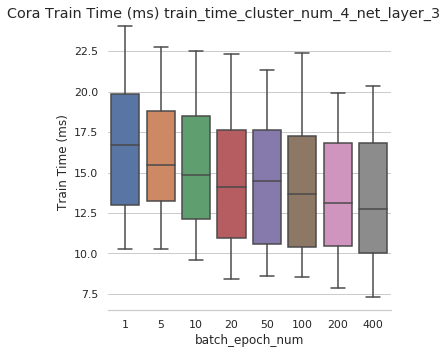

In [32]:
output_tune_param(data, data_name, image_data_path, tmp_folder, partition_nums, layers, hidden_neuron_num = 32, test_batch_num = 4)

In [ ]:
# free GPU memory
# !(nvidia-smi | grep 'python' | awk '{ print $3 }' | xargs -n1 kill -9)

In [65]:
# test the torch.tensor
import torch
import numpy as np
# a = torch.tensor([[1, 2], [2, 3]])
# b = torch.tensor([[4, 2], [2, 3]])

a = np.array([[1, 2], [2, 3]])
b = np.array([[4, 2], [2, 3]])

In [68]:
def binary_acc(y_test, y_pred):
    """
        y_test (np.array) : the true label for the nodes
        y_pred (np.array) : predicted tags for the nodes
    """
    ave_loss = (y_test == y_pred).mean(dtype=np.float).item() 
    return ave_loss

print(binary_acc(a, b))

0.75


In [69]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

print(binary_acc(a, b))

0.75


In [82]:
d = a.flatten()
e = b.flatten()
print(d.shape, e.shape)
print(accuracy_score(d, e))

(4,) (4,)
0.75
